[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/ML-AI-for-the-Working-Analyst/blob/main/Semana3/AdaBoost_detección_de_fallas.ipynb)

## Dependencias

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt

# Problema

Los datos con los que trabajaremos se pueden descargar [aqui](https://challengedata.ens.fr/participants/challenges/58/). Contiene un archivo ```7z``` que contiene las imagenes del reto.

Alternativamente, hay ligas en el notebook para descargar una versión más ligera del dataset que se obtuvo al redimensionar las imágenes a 150x128.

Las imágenes reescaladas se encuentran en un archivo ```feather``` para facilitar la lectura de los datos a un DataFrame.

Cada fila corresponde a una imagen y cada columna a sus pixeles.

## Descarga

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Curso-WorkingAnalyst/semana3/'

## Lectura

In [ ]:
# Función auxiliar para mostrar imagenes

def plot_images(rows, columns, images, title=""):
    fig = plt.figure(figsize=(15, 10))
    fig.suptitle(title, fontsize=16)

    ax = []

    for i in range(columns*rows):
        img = np.array(images.iloc[i]).reshape(150, 128)
        ax.append( fig.add_subplot(rows, columns, i+1) )
        plt.imshow(img, cmap='gray')
    # fig.tight_layout()
    
    fig.show()

In [ ]:
y = pd.read_csv(path + 'y_train_ExZpBft.csv')
y

,images,labels
0,AE00474_105028_00_4_3_2001.jpg,0
1,AE00305_043057_00_2_4_2001.jpg,1
2,AE00191_071651_00_2_2_2001.jpg,1
3,AE00191_103659_00_2_1_2001.jpg,1
4,AE00227_204647_00_3_4_2001.jpg,1
...,...,...
10604,AE00453_220334_00_4_1_2001.jpg,0
10605,AE00409_050952_00_4_2_2001.jpg,0
10606,AE00466_013823_00_1_3_2001.jpg,0
10607,AE00405_043052_00_1_4_2001.jpg,0


In [ ]:
images = pd.read_feather(path + 'data.feather')
images

,images,p0,p1,p2,p3,p4,p5,p6,p7,p8,...,p19190,p19191,p19192,p19193,p19194,p19195,p19196,p19197,p19198,p19199
0,AE00474_105028_00_4_3_2001.jpg,44,43,44,45,45,47,48,46,51,...,237,238,239,239,239,239,239,239,239,239
1,AE00305_043057_00_2_4_2001.jpg,47,48,51,53,48,50,48,55,48,...,239,239,239,239,239,239,239,239,239,239
2,AE00191_071651_00_2_2_2001.jpg,49,48,54,56,49,46,48,47,52,...,239,239,239,239,239,239,239,239,239,239
3,AE00191_103659_00_2_1_2001.jpg,50,50,55,51,50,52,52,56,50,...,239,239,239,239,239,239,239,239,239,239
4,AE00227_204647_00_3_4_2001.jpg,239,239,239,239,239,239,239,239,239,...,237,239,239,239,239,239,239,239,239,239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10604,AE00453_220334_00_4_1_2001.jpg,50,53,47,47,47,50,45,45,46,...,241,238,238,237,236,240,241,238,234,216
10605,AE00409_050952_00_4_2_2001.jpg,53,52,48,47,46,50,43,44,45,...,238,240,239,239,239,239,239,239,239,239
10606,AE00466_013823_00_1_3_2001.jpg,237,235,230,181,94,56,39,34,32,...,46,47,47,46,44,45,50,52,51,50
10607,AE00405_043052_00_1_4_2001.jpg,186,129,153,206,205,215,190,92,57,...,49,50,45,49,50,47,47,46,44,49


In [ ]:
y.set_index('images', inplace = True)
images.set_index('images', inplace=True)

In [ ]:
images

,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9,...,p19190,p19191,p19192,p19193,p19194,p19195,p19196,p19197,p19198,p19199
images,,,,,,,,,,,,,,,,,,,,,
AE00474_105028_00_4_3_2001.jpg,44,43,44,45,45,47,48,46,51,48,...,237,238,239,239,239,239,239,239,239,239
AE00305_043057_00_2_4_2001.jpg,47,48,51,53,48,50,48,55,48,45,...,239,239,239,239,239,239,239,239,239,239
AE00191_071651_00_2_2_2001.jpg,49,48,54,56,49,46,48,47,52,52,...,239,239,239,239,239,239,239,239,239,239
AE00191_103659_00_2_1_2001.jpg,50,50,55,51,50,52,52,56,50,51,...,239,239,239,239,239,239,239,239,239,239
AE00227_204647_00_3_4_2001.jpg,239,239,239,239,239,239,239,239,239,239,...,237,239,239,239,239,239,239,239,239,239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AE00453_220334_00_4_1_2001.jpg,50,53,47,47,47,50,45,45,46,47,...,241,238,238,237,236,240,241,238,234,216
AE00409_050952_00_4_2_2001.jpg,53,52,48,47,46,50,43,44,45,48,...,238,240,239,239,239,239,239,239,239,239
AE00466_013823_00_1_3_2001.jpg,237,235,230,181,94,56,39,34,32,28,...,46,47,47,46,44,45,50,52,51,50


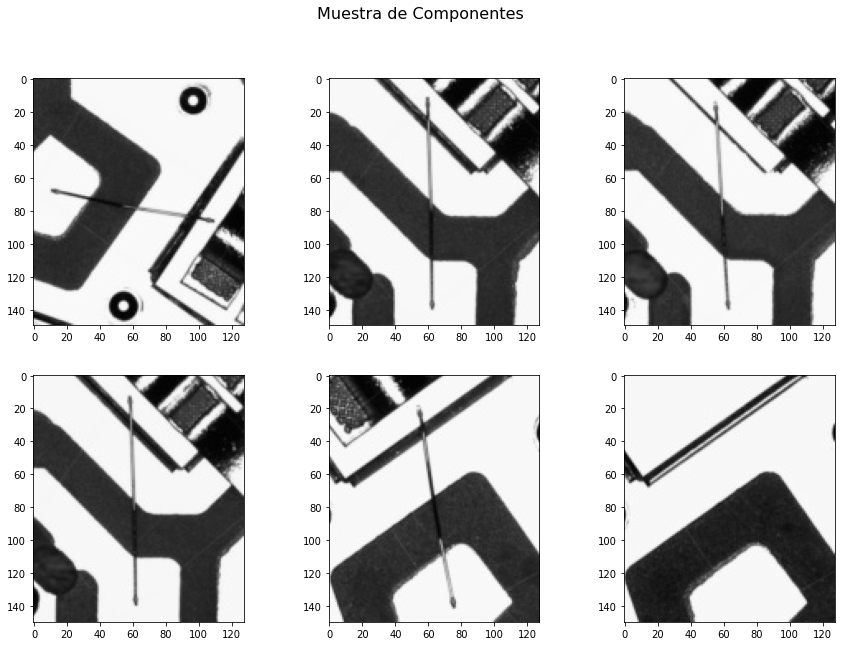

In [ ]:
rows = 2
columns = 3

plot_images(rows, columns, images.sample(rows*columns, random_state = 10), "Muestra de Componentes")

In [ ]:
np.array(images.iloc[0, :]).reshape((150, 128))

array([[ 44,  43,  44, ..., 113,  64,  55],
       [ 46,  46,  47, ..., 180,  82,  61],
       [ 48,  49,  51, ..., 226, 124,  67],
       ...,
       [171, 148, 127, ..., 239, 239, 239],
       [220, 206, 186, ..., 239, 239, 239],
       [239, 235, 233, ..., 239, 239, 239]])

In [ ]:
for i in images.columns:
  images[i] = images[i].apply(lambda x: 0 if x<=60 else 1)

In [ ]:
np.array(images.iloc[0, :]).reshape((150, 128))

array([[0, 0, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

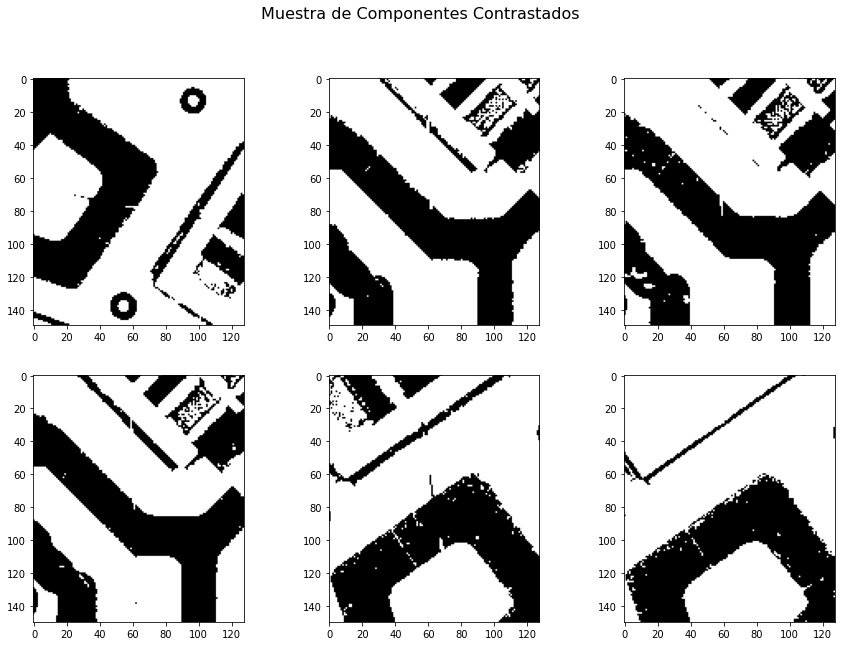

In [ ]:
rows = 2
columns = 3

plot_images(rows, columns, images.sample(rows*columns, random_state = 10), "Muestra de Componentes Contrastados")

## Exploración

In [ ]:
y

,labels
images,
AE00474_105028_00_4_3_2001.jpg,0
AE00305_043057_00_2_4_2001.jpg,1
AE00191_071651_00_2_2_2001.jpg,1
AE00191_103659_00_2_1_2001.jpg,1
AE00227_204647_00_3_4_2001.jpg,1
...,...
AE00453_220334_00_4_1_2001.jpg,0
AE00409_050952_00_4_2_2001.jpg,0
AE00466_013823_00_1_3_2001.jpg,0


In [ ]:
y.labels.value_counts()

1    6582
0    4027
Name: labels, dtype: int64

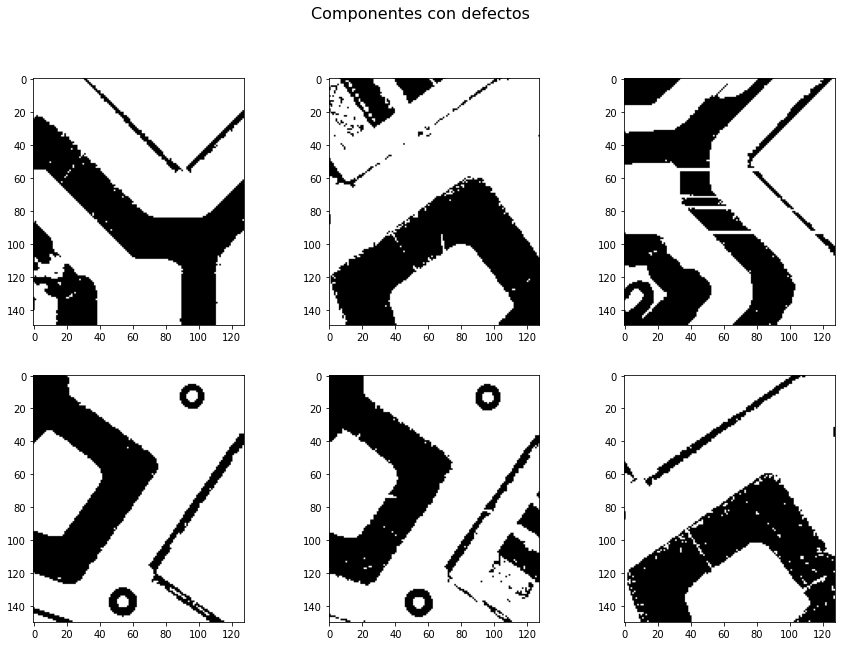

In [ ]:
rows = 2
columns = 3

plot_images(rows, columns, images[y.labels == 0].sample(rows*columns, random_state = 10), "Componentes con defectos")

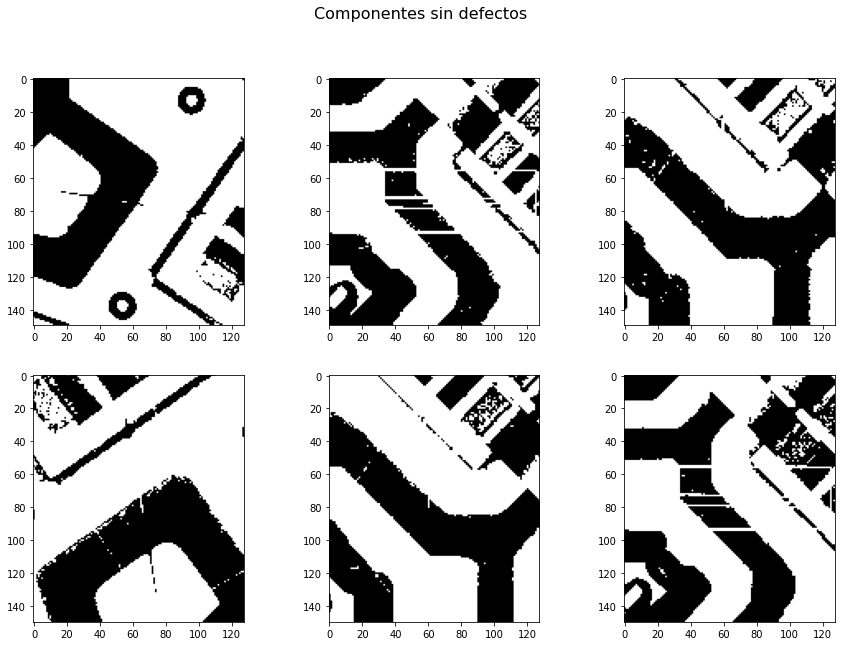

In [ ]:
plot_images(rows, columns, images[y.labels == 1].sample(rows*columns, random_state = 10), "Componentes sin defectos")

## División en set de prueba y entrenamiento

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, y, train_size = .7, random_state = 10)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

In [ ]:
# PRUEBA
X_train, X_test, y_train, y_test = train_test_split(images, y, train_size = .7, random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7426, 19200) (3183, 19200) (7426, 1) (3183, 1)


# Clasificación

## Árbol de decisión

In [ ]:
clf_tree = DecisionTreeClassifier(max_depth = 2)
tree_train_pred = clf_tree.fit(X_train, y_train.labels.ravel()).predict(X_train)
print(classification_report(y_train, tree_train_pred, digits = 3))

              precision    recall  f1-score   support

           0      0.925     0.841     0.881      2814
           1      0.908     0.959     0.933      4612

    accuracy                          0.914      7426
   macro avg      0.917     0.900     0.907      7426
weighted avg      0.915     0.914     0.913      7426



In [ ]:
tree_test_pred = clf_tree.predict(X_test)
print(classification_report(y_test, tree_test_pred, digits = 3))

              precision    recall  f1-score   support

           0      0.935     0.838     0.883      1213
           1      0.906     0.964     0.934      1970

    accuracy                          0.916      3183
   macro avg      0.920     0.901     0.909      3183
weighted avg      0.917     0.916     0.915      3183



In [ ]:
print('\nSet de entrenamiento:')
print(confusion_matrix(y_train, tree_train_pred))
print('\nSet de prueba:')
print(confusion_matrix(y_test, tree_test_pred))


Set de entrenamiento:
[[2366  448]
 [ 191 4421]]

Set de prueba:
[[1016  197]
 [  71 1899]]


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

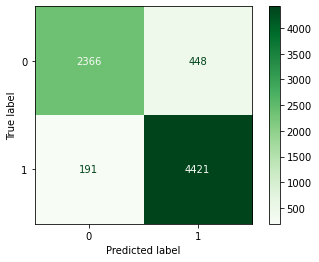

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, tree_train_pred, cmap=plt.cm.Greens)

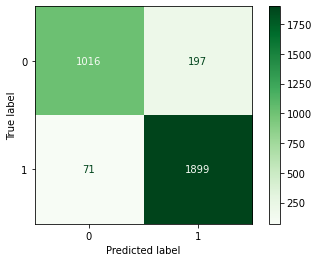

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, tree_test_pred, cmap=plt.cm.Greens)

## Sobre el árbol de decisión

In [ ]:
# https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py

n_nodes = clf_tree.tree_.node_count
children_left = clf_tree.tree_.children_left
children_right = clf_tree.tree_.children_right
feature = clf_tree.tree_.feature
threshold = clf_tree.tree_.threshold

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node.".format(
                space=node_depth[i] * "\t", node=i
            )
        )
    else:
        print(
            "{space}node={node} is a split node: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature[i],
                threshold=threshold[i],
                right=children_right[i],
            )
        )

The binary tree structure has 7 nodes and has the following tree structure:

node=0 is a split node: go to node 1 if X[:, 13639] <= 0.5 else to node 4.
	node=1 is a split node: go to node 2 if X[:, 1855] <= 0.5 else to node 3.
		node=2 is a leaf node.
		node=3 is a leaf node.
	node=4 is a split node: go to node 5 if X[:, 9379] <= 0.5 else to node 6.
		node=5 is a leaf node.
		node=6 is a leaf node.


## Visualización del árbol

In [ ]:
from sklearn import tree

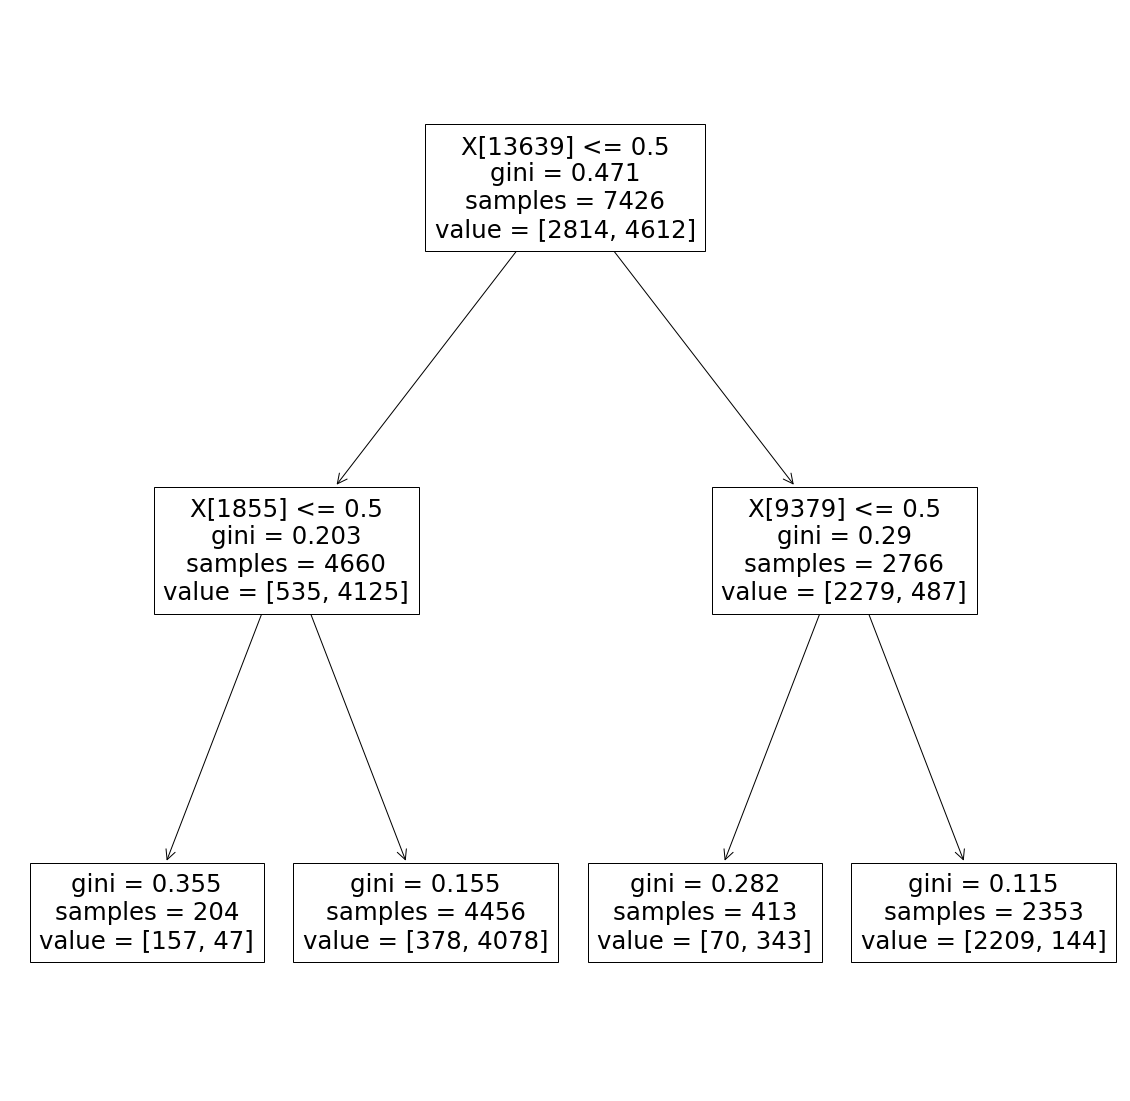

In [ ]:
plt.figure(figsize=(20, 20))
tree.plot_tree(clf_tree)
plt.show()

## Pixeles en los que se basa el árbol para clasificar

In [ ]:
def pos2coord(pos, cols):
    return pos//cols, pos%cols

In [ ]:
coords = [pos2coord(x,128) for x in clf_tree.tree_.feature[clf_tree.tree_.feature != -2]]
coords

[(106, 71), (14, 63), (73, 35)]

In [ ]:
from matplotlib.patches import Circle
from matplotlib.patheffects import withStroke

def plot_images_circle(rows, columns, images, circles, title=""):
    fig = plt.figure(figsize=(15, 10))
    fig.suptitle(title, fontsize=16)

    ax = []

    for i in range(columns*rows):
        img = np.array(images.iloc[i]).reshape(150, 128)
        ax.append( fig.add_subplot(rows, columns, i+1) )
        for circle in circles:
            ax[-1].add_artist(Circle(circle[::-1], 2, clip_on=False, zorder=10, linewidth=1,
                        edgecolor='red', facecolor=(0, 0, 0, .0125),
                        path_effects=[withStroke(linewidth=3, foreground='w')]))
        plt.imshow(img, cmap='gray')
    # fig.tight_layout()
    
    fig.show()

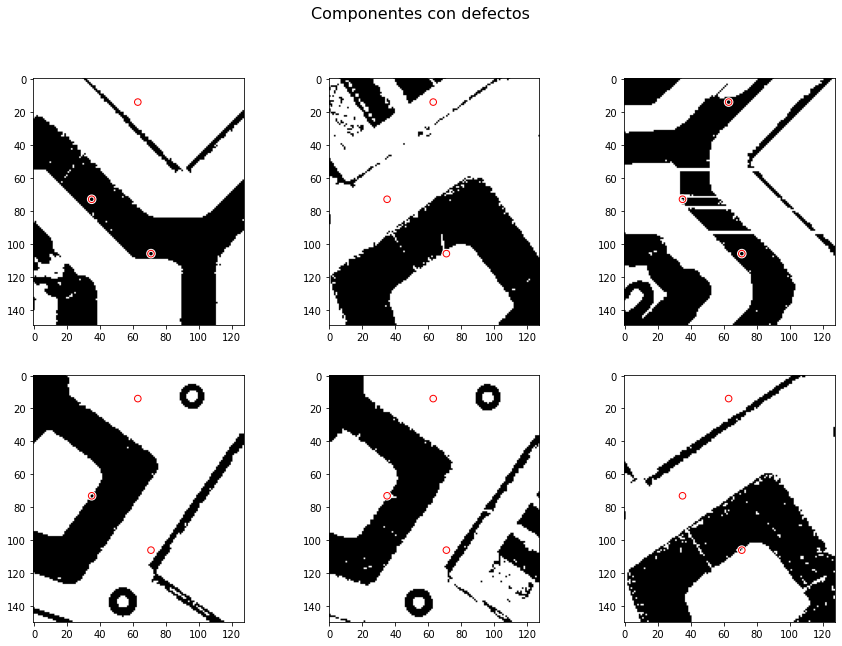

In [ ]:
rows = 2
columns = 3
plot_images_circle(rows, columns, images[y.labels == 0].sample(rows*columns, random_state = 10), coords, "Componentes con defectos")

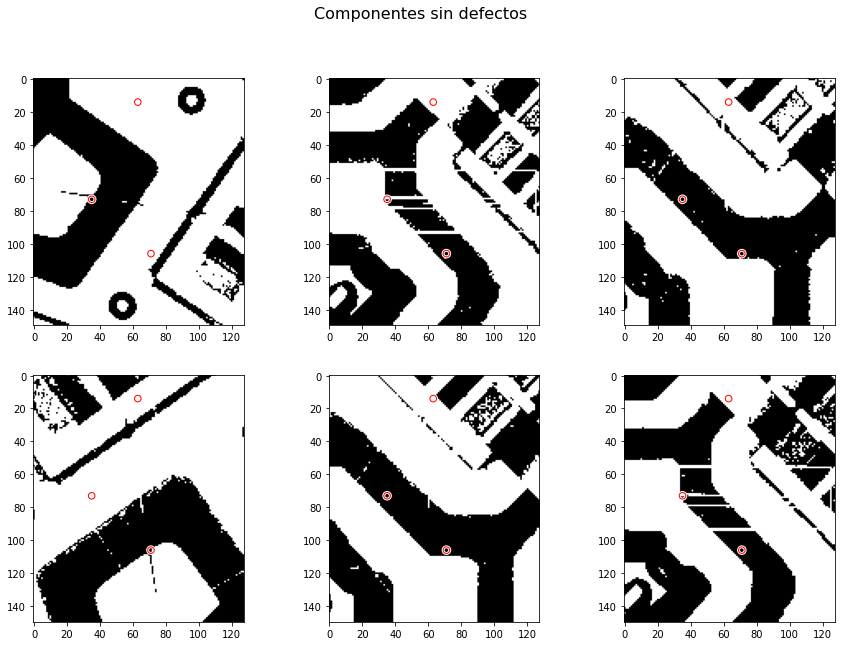

In [ ]:
plot_images_circle(rows, columns, images[y.labels == 1].sample(rows*columns, random_state = 10), coords, "Componentes sin defectos")

# Random Forest


In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf_rf = RandomForestClassifier(max_depth=5)

rf_train_pred = clf_rf.fit(X_train, y_train.labels.ravel()).predict(X_train)

print(classification_report(y_train, rf_train_pred, digits = 3))

              precision    recall  f1-score   support

           0      0.866     0.933     0.898      2814
           1      0.957     0.912     0.934      4612

    accuracy                          0.920      7426
   macro avg      0.911     0.922     0.916      7426
weighted avg      0.922     0.920     0.920      7426



In [ ]:
rf_test_pred = clf_rf.predict(X_test)

In [ ]:
print('\nSet de entrenamiento:')
print(confusion_matrix(y_train, rf_train_pred))
print('\nSet de prueba:')
print(confusion_matrix(y_test, rf_test_pred))


Set de entrenamiento:
[[2626  188]
 [ 408 4204]]

Set de prueba:
[[1127   86]
 [ 189 1781]]


In [ ]:
clf_rf.estimators_[1]

DecisionTreeClassifier(max_depth=5, max_features='auto',
                       random_state=1474531965)

## AdaBoost (Árboles de decisión con boosting)

In [ ]:
clf_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2))

ada_train_pred = clf_ada.fit(X_train, y_train.labels.ravel()).predict(X_train)

print(classification_report(y_train, ada_train_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2814
           1       0.99      1.00      1.00      4612

    accuracy                           1.00      7426
   macro avg       1.00      0.99      1.00      7426
weighted avg       1.00      1.00      1.00      7426



In [ ]:
ada_test_pred = clf_ada.predict(X_test)

print(classification_report(y_test, ada_test_pred, digits = 3))

              precision    recall  f1-score   support

           0      0.978     0.969     0.974      1213
           1      0.981     0.987     0.984      1970

    accuracy                          0.980      3183
   macro avg      0.980     0.978     0.979      3183
weighted avg      0.980     0.980     0.980      3183



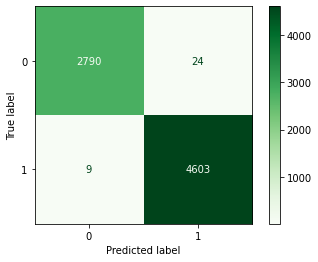

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, ada_train_pred, cmap=plt.cm.Greens)

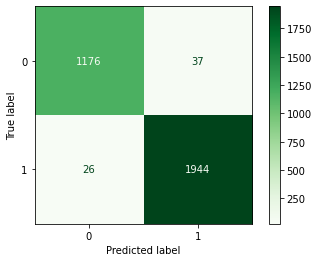

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, ada_test_pred, cmap=plt.cm.Greens)

In [ ]:
errores = y_test.labels != ada_test_pred
errores

images
AE00343_222551_00_1_3_2001.jpg    False
AE00367_163909_00_3_3_2001.jpg    False
AE00346_145652_00_3_3_2001.jpg    False
AE00343_225645_00_2_1_2001.jpg    False
AE00343_171010_00_3_4_2001.jpg    False
                                  ...  
AE00309_164423_00_2_1_2001.jpg    False
AE00427_131249_00_4_1_2001.jpg    False
AE00331_101012_00_2_3_2001.jpg    False
AE00354_101600_00_3_3_2001.jpg    False
AE00385_123408_00_1_2_2001.jpg    False
Name: labels, Length: 3183, dtype: bool

In [ ]:
errores.value_counts()

False    3120
True       63
Name: labels, dtype: int64

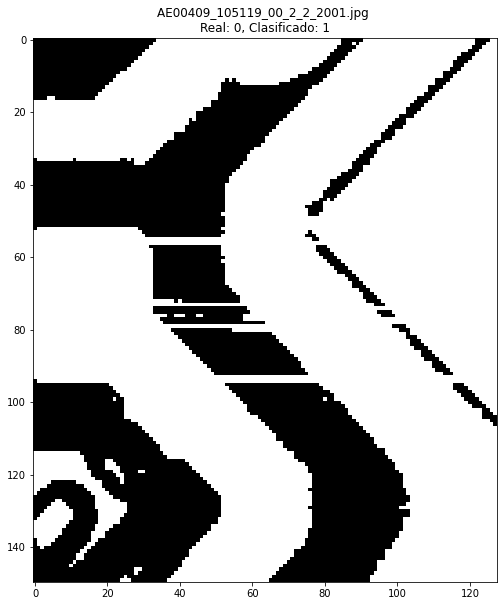

In [ ]:
index = np.random.randint(0, len(errores[errores]))

plt.figure(figsize=(10, 10))
plt.imshow(np.array(X_test[errores].iloc[index, :]).reshape(150, 128), cmap = 'gray')
plt.title(f'{y_test[errores].index[index]} \nReal: {y_test[errores].values[index][0]}, Clasificado: {ada_test_pred[errores][index]}')
plt.show()

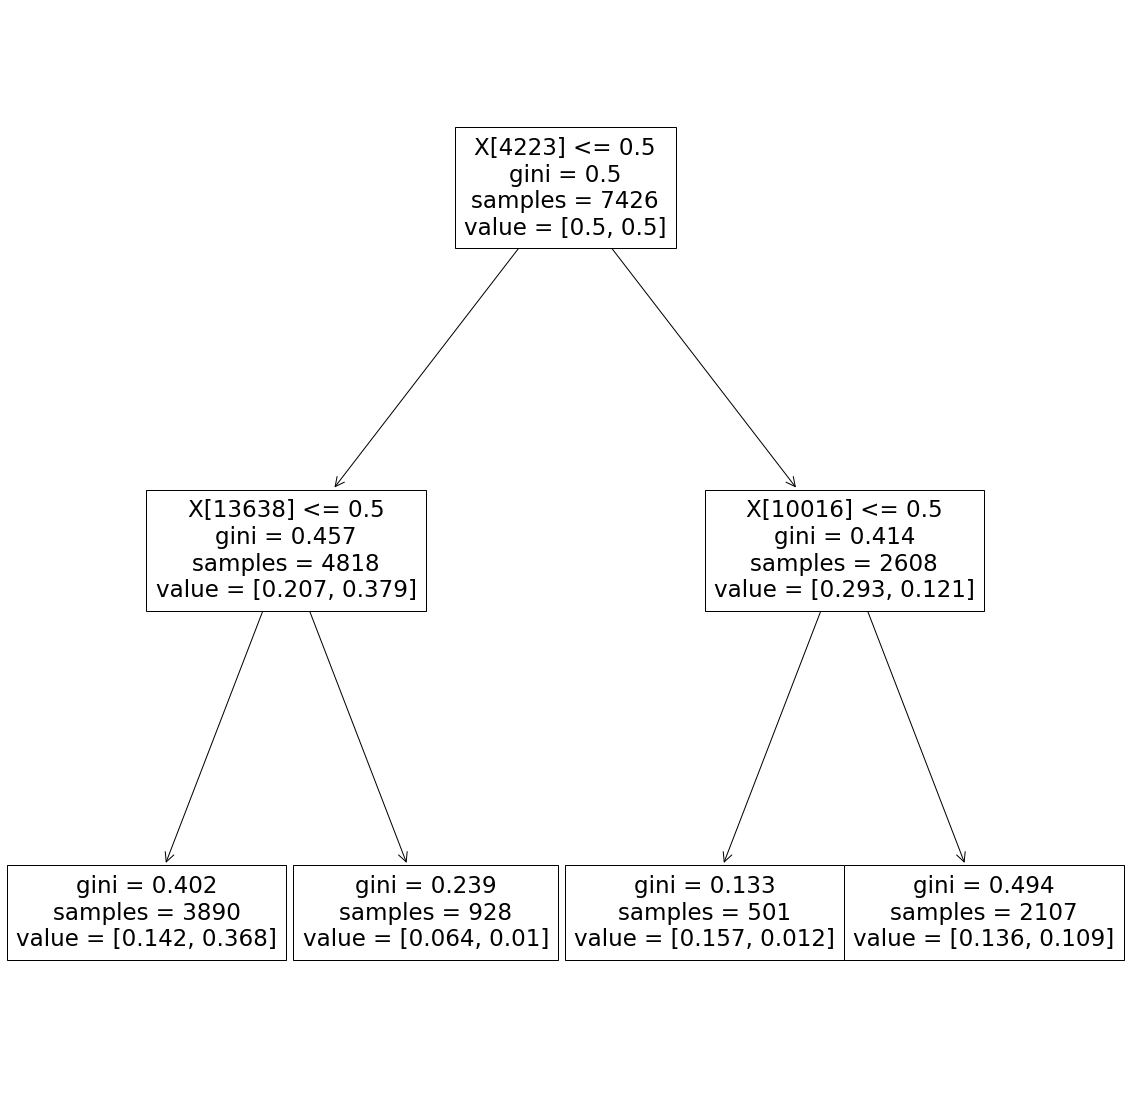

In [ ]:
plt.figure(figsize=(20, 20))
tree.plot_tree(clf_ada.estimators_[1])
plt.show()

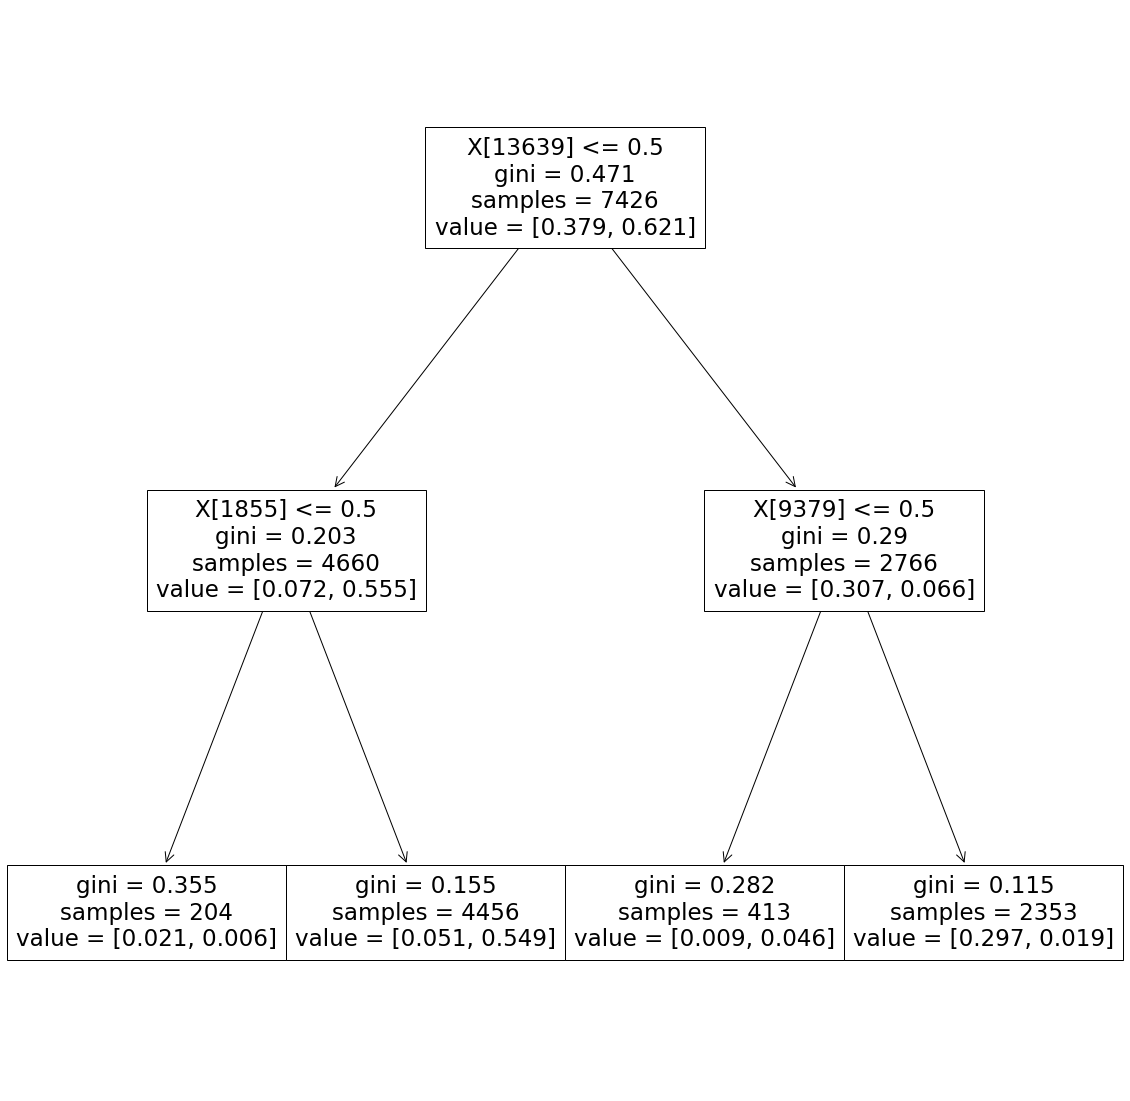

In [ ]:
plt.figure(figsize=(20, 20))
tree.plot_tree(clf_ada.estimators_[0])
plt.show()

In [ ]:
clf_ada.estimators_[0]

DecisionTreeClassifier(max_depth=2, random_state=1078047706)

In [ ]:
clf_ada.estimator_weights_

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])